In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch
from tqdm import tqdm
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib inline

# Add the parent directory to the Python path - bad practice, but it's just for the example
import sys
sys.path.append("..")

from src.glocal_analysis import run_analysis 
from src.datasets.flood_dataset import FloodDataset
from src.datasets.DLR_dataset import DatasetDLR
from src.plot_crp_explanations import plot_explanations, plot_one_image_explanation
from src.minio_client import MinIOClient
from LCRP.models import get_model 

/home/heydari/.virtualenvs/TEMA-FHHI-PY/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
device

'cuda'

: 

In [5]:
model = get_model(model_name="unet", device=device, classes=1, ckpt_path="../models/model_s2burnt_modified.pt", in_channels=4, encoder_name="resnet50")

Loaded checkpoint ../models/model_s2burnt_modified.pt


In [6]:
!ls ../../DLR_data/dlr_germany/

S2A_MSIL2A_20210718T103031_R108_T31UGS_20210719T012705
S2A_MSIL2A_20210721T104031_R008_T31UGS_20210721T214914


## Load a test image into a DatasetDLR

In [50]:
dlr_sardinia_image1 = "../../DLR_data/dlr_sardinia/S2A_MSIL2A_20210814T102031_N0301_R065_T32TMK_20210814T132326.SAFE"
dlr_sardinia_image2 = "../../DLR_data/dlr_sardinia/S2B_MSIL2A_20210710T101559_N0301_R065_T32TMK_20210710T132321.SAFE"
dlr_sardinia_image3 = "../../DLR_data/dlr_sardinia/S2B_MSIL2A_20210730T101559_N0301_R065_T32TMK_20210730T135122.SAFE"

dlr_kuhmo_image1 = "../../DLR_data/dlr_kuhmo/S2B_MSIL2A_20240605T094549_N0510_R079_T35WPM_20240605T112203.SAFE"

dlr_germany_image1 = "../../DLR_data/dlr_germany/S2A_MSIL2A_20210718T103031_R108_T31UGS_20210719T012705" 
dlr_germany_image2 = "../../DLR_data/dlr_germany/S2A_MSIL2A_20210721T104031_R008_T31UGS_20210721T214914"

In [51]:
img_dir = dlr_germany_image1

In [52]:
test_image_dataset = DatasetDLR(
    img_dir=img_dir,
    mask_dir=None,
    normalize_means_stds=[
        [0.1161, 0.1065, 0.1036, 0.2059],  # Means
        [0.0556, 0.0570, 0.0772, 0.1033]   # Stds
    ]
)

Loading images: 100%|██████████| 1/1 [00:00<00:00, 15.44it/s]


In [53]:
test_image_dataset.img_arr.shape

(48, 256, 256, 4)

In [54]:
reference_dataset = DatasetDLR(
    img_dir="../../DLR_data/fire_data/train_tiled/img", 
    mask_dir="../../DLR_data/fire_data/train_tiled/msk", 
    normalize_means_stds=[
        [0.1161, 0.1065, 0.1036, 0.2059],  # Means
        [0.0556, 0.0570, 0.0772, 0.1033]   # Stds
    ]
)

Loading masks: 100%|██████████| 731/731 [00:00<00:00, 1436.11it/s]


In [12]:
reference_dataset.img_arr.shape

(731, 256, 256, 4)

In [ ]:
# Setting up main parameters
model_name = "unet"
output_dir = "../output/crp/unet_fire_DLR"
class_id = 0
sample_id = 10
n_concepts = 3
n_refimgs = 12
layer = "encoder.layer3.0.conv1"
mode = "relevance"
prediction_num = 0

test_img, test_mask = test_image_dataset[sample_id]


fig = plot_one_image_explanation(model_name, model, test_img, reference_dataset, class_id, layer, prediction_num, mode, n_concepts, n_refimgs, output_dir=output_dir)

## Run analysis for all tiles of a given test image

Processing ../../DLR_data/dlr_kuhmo/S2B_MSIL2A_20240605T094549_N0510_R079_T35WPM_20240605T112203.SAFE


  0%|          | 0/3025 [00:00<?, ?it/s]/Users/kortukov/miniconda3/envs/tema/lib/python3.8/site-packages/zennit/image.py:187: RuntimeWarning: invalid value encountered in divide
  array = (array - vmin) / (vmax - vmin)
/Users/kortukov/miniconda3/envs/tema/lib/python3.8/site-packages/zennit/image.py:188: RuntimeWarning: invalid value encountered in cast
  array = (array * 255).clip(0, 255).astype(np.uint8)


Concepts: torch.return_types.topk(
values=tensor([0., 0., 0.]),
indices=tensor([2, 0, 1]))
Computing reference images...
Plotting...


  0%|          | 1/3025 [00:24<20:20:21, 24.21s/it]

Concepts: torch.return_types.topk(
values=tensor([0.0125, 0.0108, 0.0107]),
indices=tensor([544, 754,  62]))
Computing reference images...


  0%|          | 1/3025 [00:34<28:33:43, 34.00s/it]


KeyboardInterrupt: 

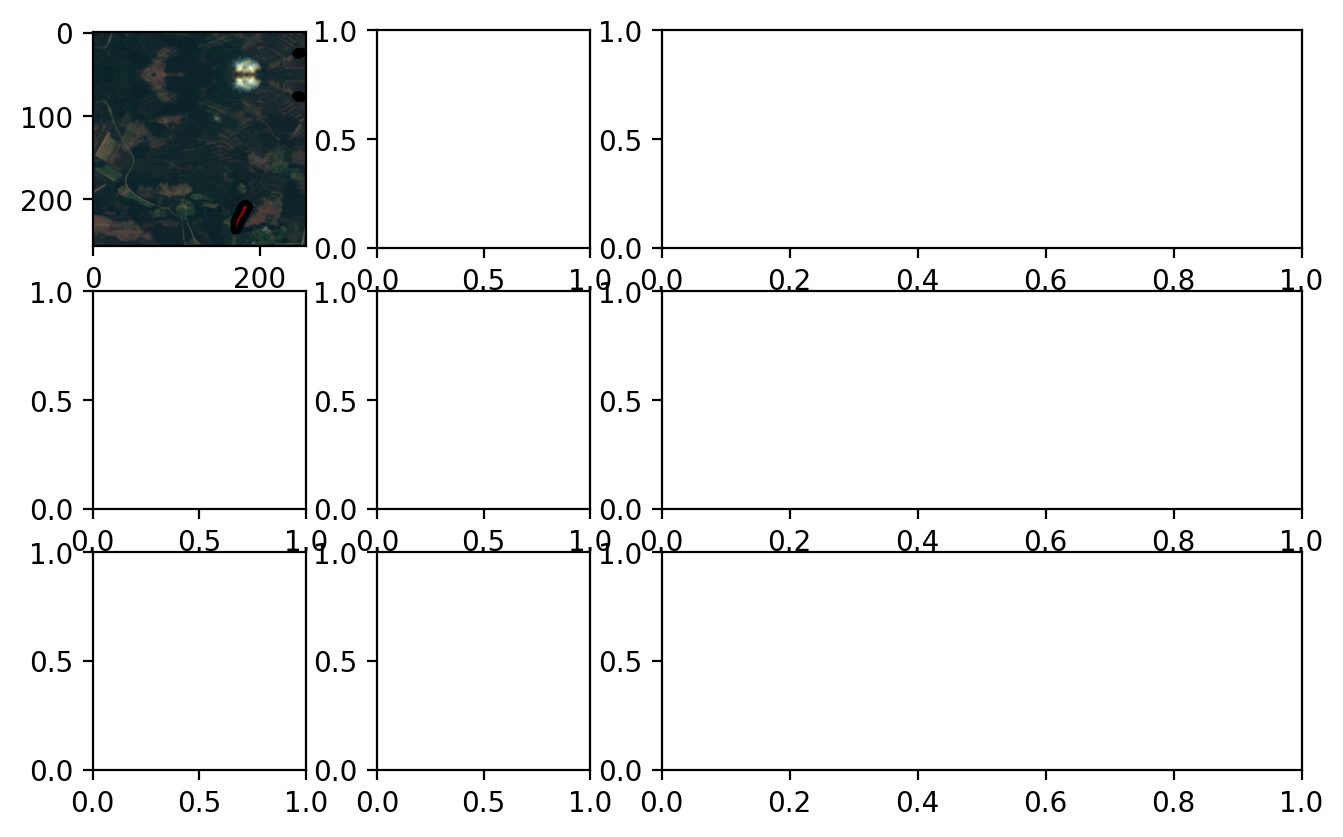

In [56]:
# Setting up main parameters
model_name = "unet"
output_dir = "../output/crp/unet_fire_DLR"
class_id = 0
n_concepts = 3
n_refimgs = 12
layer = "encoder.layer3.0.conv3"
mode = "relevance"
prediction_num = 0


test_image_directories = [
    # dlr_germany_image1,
    # dlr_germany_image2,
    # dlr_sardinia_image1,
    # dlr_sardinia_image2,
    # dlr_sardinia_image3,
    dlr_kuhmo_image1,
    ]

for img_dir in test_image_directories:
    print(f"Processing {img_dir}")

    test_image_dataset = DatasetDLR(
        img_dir=img_dir,
        mask_dir=None,
        normalize_means_stds=[
            [0.1161, 0.1065, 0.1036, 0.2059],  # Means
            [0.0556, 0.0570, 0.0772, 0.1033]   # Stds
        ]
    )

    xai_results_dir = os.path.join(img_dir, "xai_results")
    layer_str = layer.replace(".", "_")
    layer_results_dir = os.path.join(xai_results_dir, layer_str)

    os.makedirs(layer_results_dir, exist_ok=True)


    for sample_id in tqdm(range(len(test_image_dataset))):
        test_img, test_mask = test_image_dataset[sample_id]

        # Save source image
        normalized_img = np.array(test_img.cpu().numpy())  # Assuming test_img is a tensor
        normalized_img = np.transpose(normalized_img[:3, :, :], (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
        normalized_img = ((normalized_img - normalized_img.min()) / (normalized_img.max() - normalized_img.min()) * 255).astype(np.uint8)
        
        # Save the properly normalized image
        plt.imsave(os.path.join(layer_results_dir, f"sample_{sample_id}_src.png"), normalized_img)

        fig = plot_one_image_explanation(model_name, model, test_img, reference_dataset, class_id, layer, prediction_num, mode, n_concepts, n_refimgs, output_dir=output_dir)

        fig.savefig(os.path.join(layer_results_dir, f"sample_{sample_id}.png"))

        plt.close(fig)


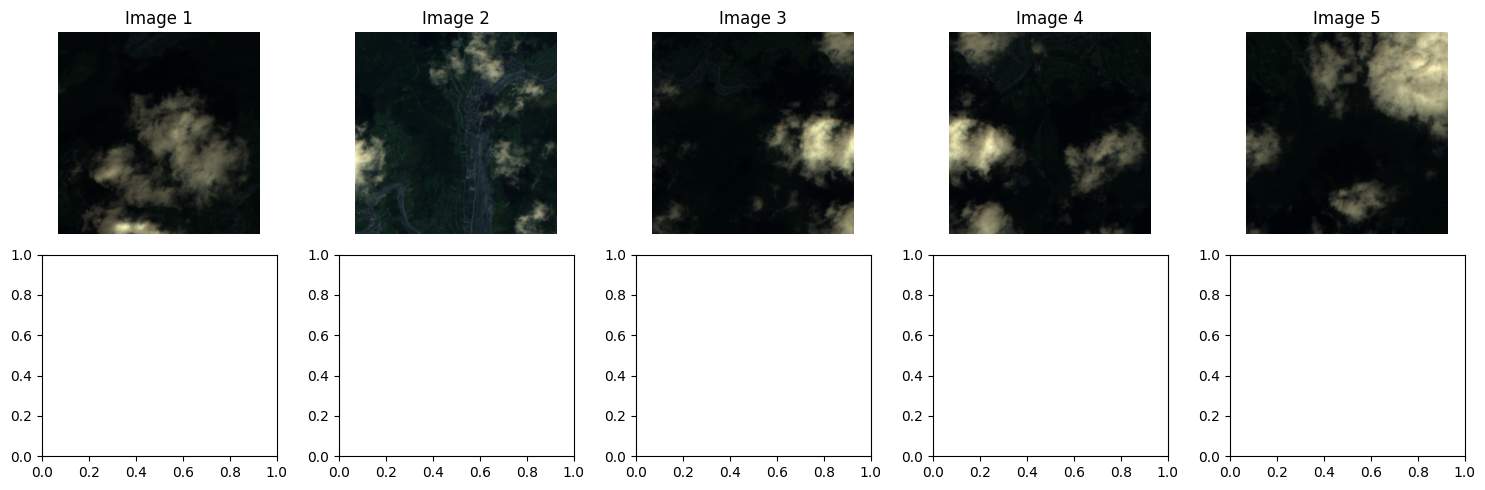

In [36]:
# Visualize 5 images and their masks
num_images = 5
idx_start = 10
fig, axes = plt.subplots(2, num_images, figsize=(15, 5))  # 2 rows (Images, Masks)

for i in range(num_images):
    image, _ = test_image_dataset[i + idx_start]  # Get image-mask pair
    image = np.array(((image - image.min()) / (image.max() - image.min()) * 255)).astype(np.uint8)
    image = np.transpose(image[:3, :, :], (1, 2, 0))  # Convert to (H, W, C)
    # mask = mask.squeeze() # Remove channel dim

    # Top row: Images
    axes[0, i].imshow(image)
    axes[0, i].set_title(f"Image {i+1}")
    axes[0, i].axis("off")

    # Bottom row: Masks
    # axes[1, i].imshow(mask, cmap="gray")
    # axes[1, i].set_title(f"Mask {i+1}")
    # axes[1, i].axis("off")

# Adjust layout
plt.tight_layout()
plt.show()

# print(f"Dataset size: {len(dataset)}")